## Battle at The Berrics
<a href="https://www.youtube.com/results?search_query=BATB+the+berrics">The battles at The Berrics</a> are a famous skateboarding competition in which skateboarders compete against each other. The idea behind this network is to see how skateboarders competed along the 10 issues of the battles. As each battle is one Youtube, I used Youtube's API to get the data for the network.
For each video, the following piece of information was extracted:
* Skateboarders
* Issue of battle (from 1 to 10, or X)
* Round in the issue
* Number of views on Youtube

CyREST was important to create the network and visualize the most watched videos and skateboarders. I also created an animation to see the order of battles for a given skateboarder.

In [1]:
# Import the modules
import pandas as pd
import numpy as np
import networkx as nx
import requests
import json

In [2]:
# Creating the networks
from py2cytoscape.data.cynetwork import CyNetwork
from py2cytoscape.data.cyrest_client import CyRestClient
from py2cytoscape.data.style import StyleUtil
import py2cytoscape.cytoscapejs as renderer

<IPython.core.display.Javascript object>

In [3]:
API_Key = "[your_youtube_API_here]"
channelId = "UCVq1Crat76rKsgu6WosKwmA" # The Berrics

In [4]:
# Getting battles data from Youtube
for batb_issue in range(1,10)+['X']:
    print batb_issue
    if batb_issue == 'X':
        json_text = requests.get("https://www.googleapis.com/youtube/v3/search?key="+API_Key+"&channelId="+channelId+"&q=BATB+"+batb_issue+"&part=snippet,id&order=date&maxResults=50").json()
    else:
        json_text = requests.get("https://www.googleapis.com/youtube/v3/search?key="+API_Key+"&channelId="+channelId+"&q=BATB"+str(batb_issue)+"&part=snippet,id&order=date&maxResults=50").json()

    # From the json text, retrive the list of trials by using the key
    videos = json_text['items']

    # Using pandas functions, convert the JSON into a Data Frame
    videos_df = pd.io.json.json_normalize(videos)
    videos_df.dropna(subset=['id.videoId'], inplace=True)

    viewCounts = []
    likeCounts = []
    dislikeCounts = []
    for i in videos_df.index:
        video_title = videos_df['snippet.title'][i]
        video_id = videos_df['id.videoId'][i]
        #print(video_title)
        json_text2 = requests.get("https://www.googleapis.com/youtube/v3/videos?id="+video_id+"&key="+API_Key+"&fields=items(id,snippet(channelId,title,categoryId),statistics)&part=snippet,statistics").json()
        viewCount     = json_text2['items'][0]['statistics']['viewCount'] 
        likeCount     = json_text2['items'][0]['statistics']['likeCount'] 
        dislikeCount  = json_text2['items'][0]['statistics']['dislikeCount']
        #print(video_title, viewCount, likeCount, dislikeCount)
        viewCounts.append(viewCount)
        likeCounts.append(likeCount)
        dislikeCounts.append(dislikeCount)
    
    # Merging all videos
    temp_df = videos_df.loc[:, ['id.videoId', 'snippet.title']]
    temp_df['BATB'] = videos_df.shape[0] * [batb_issue]
    temp_df['viewCount'] = viewCounts
    temp_df['likeCount'] = likeCounts
    temp_df['dislikeCount'] = dislikeCounts
    if batb_issue == 1:
        all_videos_df = temp_df
    else:
        all_videos_df = all_videos_df.append(temp_df)


1
2
3
4
5
6
7
8
9
X


In [5]:
# Saving videos table
all_videos_df.to_csv('all_videos_batb_2017-05-31.csv')
#all_videos_df = pd.read_csv('all_videos_batb.csv')

In [6]:
# Showing first rows
all_videos_df.head()

,id.videoId,snippet.title,BATB,viewCount,likeCount,dislikeCount
0,Q0IFt9SsHk8,Best of Battle at The Berrics: Highlights - BATB1,1,28461,172,1
1,eGTsIL-xJB8,Mike Mo Capaldi Vs Furby: BATB1 - Round 1,1,55319,424,3
2,3lqNen-Qccw,Brandon Biebel Vs Nick McLouth: BATB1 - Round 1,1,15620,134,0
3,YX7Vr0QUedk,Marc Johnson Vs Johnny Layton: BATB1 - Round 2,1,11374,67,0
4,EwcnZDzs4BI,Benny Fairfax Vs PJ Ladd: BATB1 - Finals,1,25665,209,1


In [7]:
# Creating network
skaters_net = nx.DiGraph()
battle_rounds = ['Round 1', 'Round 2', 'Round 3', 'Finals', '3rd Place Battle', 'Championship Battle']

for row in all_videos_df.iterrows():
    videoId     = row[1]['id.videoId']
    video_title = row[1]['snippet.title']
    batb_issue  = str(row[1]['BATB'])
    viewCount   = row[1]['viewCount']

    skaters = []
    if batb_issue == 'X':
        if not video_title.find('Before The Battle') >= 0 and not video_title.find('Unsanctioned Battle') >= 0 \
               and video_title.startswith('BATB X |') and video_title.find('vs.')>=0:
            skaters = video_title[9:].split(' - Round')[0].split(' vs. ')
            #print (skaters, batb_issue, video_title)
    elif batb_issue == '9':
        if video_title.find(' Vs ') >= 0 and not video_title.find('Prologue') >= 0:
            skaters = video_title.replace('BATB9 | ', '').split(':')[0].split(' Vs ')
            if len(skaters)>1 and skaters[1].find('-')>=0:
                skaters[1] = skaters[1].split(' -')[0]
            #print (skaters, batb_issue, video_title)
    else:
        if video_title.find(' Vs ') >= 0 and not video_title.find('Throwback') >= 0:
            skaters = video_title.split(':')[0].split(' Vs ')
            if len(skaters)>1 and skaters[1].find('-')>=0:
                skaters[1] = skaters[1].split(' -')[0]
            #print (skaters, batb_issue, video_title)
    
    for battle_round in battle_rounds:
        if video_title.find(battle_round) >= 0:
            this_battle_round = battle_round
    
    if len(skaters) > 1:
        for skater in skaters:
            if not skater in skaters_net.nodes():
                skaters_net.add_node(skater, {'name':skater, 'viewAvg':int(viewCount), 'viewCount':int(viewCount), 'issues':batb_issue, 'n_issues':1, 'n_videos':1})
            else:
                skaters_net.node[skater]['viewCount'] += int(viewCount)
                skaters_net.node[skater]['n_videos'] += 1
                skaters_net.node[skater]['viewAvg'] = skaters_net.node[skater]['viewCount'] / skaters_net.node[skater]['n_videos']
                if not batb_issue == skaters_net.node[skater]['issues'].split(', ')[-1]:
                    skaters_net.node[skater]['issues'] += ', ' + batb_issue
                    skaters_net.node[skater]['n_issues'] += 1
        try:
            skaters_net.add_edge(skaters[0], skaters[1], {'batb_issue':batb_issue, 'round':this_battle_round, 'videoId':videoId, 'video_title':video_title, 'viewCount':int(viewCount)})
        except:
            print '*****', skaters
    

In [8]:
# Showing first 4 skateboarders
skaters_net.nodes(data=True)[:4]

[(u'Jeron Wilson',
  {'issues': '1',
   'n_issues': 1,
   'n_videos': 1,
   'name': u'Jeron Wilson',
   'viewAvg': 16712,
   'viewCount': 16712}),
 (u'Bobby Worrest',
  {'issues': '9',
   'n_issues': 1,
   'n_videos': 1,
   'name': u'Bobby Worrest',
   'viewAvg': 70884,
   'viewCount': 70884}),
 (u'Chico Brenes',
  {'issues': '1, 3',
   'n_issues': 2,
   'n_videos': 4,
   'name': u'Chico Brenes',
   'viewAvg': 13652,
   'viewCount': 54611}),
 (u'Michael Sommer',
  {'issues': '9',
   'n_issues': 1,
   'n_videos': 4,
   'name': u'Michael Sommer',
   'viewAvg': 95400,
   'viewCount': 381601})]

In [9]:
skaters_table = pd.DataFrame(columns = skaters_net.nodes(data=True)[0][1].keys())
for skater in skaters_net.nodes(data=True):
    skaters_table = skaters_table.append(pd.Series(skaters_net.node[skater[0]]), ignore_index=True)

skaters_table.to_csv('skaters_table.csv')

In [10]:
# Showing first 4 battles
skaters_net.edges(data=True)[:4]

[(u'Jeron Wilson',
  u'Mike Carroll',
  {'batb_issue': '1',
   'round': 'Round 1',
   'videoId': u'T7hRpU2a8WQ',
   'video_title': u'Jeron Wilson Vs Mike Carroll: BATB1 - Round 1',
   'viewCount': 16712}),
 (u'Bobby Worrest',
  u'Youness Amrani',
  {'batb_issue': '9',
   'round': 'Round 2',
   'videoId': u'Fyee6J4BCss',
   'video_title': u'BATB9 | Bobby Worrest Vs Youness Amrani - Round 2',
   'viewCount': 70884}),
 (u'Chico Brenes',
  u'Mike Mo Capaldi',
  {'batb_issue': '1',
   'round': 'Round 2',
   'videoId': u's3mzDwF2Za4',
   'video_title': u'Chico Brenes Vs Mike Mo Capaldi: BATB1 - Round 2',
   'viewCount': 8450}),
 (u'Chico Brenes',
  u'Dennis Busenitz',
  {'batb_issue': '3',
   'round': 'Round 1',
   'videoId': u'onLCnz77BXY',
   'video_title': u'Chico Brenes Vs Dennis Busenitz: BATB3 - Round 1',
   'viewCount': 7275})]

In [11]:
# Function to set value to nodes/edges in the network
def set_value(ids, value):
    new_values = {}
    for element_id in ids:
        new_values[element_id] = value
    return new_values

In [12]:
# The code below is based on py2cytoscape tutorials

# Creating py2cytoscape client
cy = CyRestClient()

# Reset session
cy.session.delete()

# Creating network with Cytoscape from NetworkX
cy_net = cy.network.create_from_networkx(skaters_net, name='BATB Network')

# Get views for a network: Cytoscape "may" have multiple views, and that's why it returns list instead of an object.
view_id_list = cy_net.get_views() 

# Display IDs of available views
print('Succesfully created networks with the following views (ids):')
print(view_id_list)

# The "format" option specify the return type.
view = cy_net.get_view(view_id_list[0], format='view')

# Applying circular layout
cy.layout.apply(name='circular', network=cy_net)

# Getting attributes from network to use in view (node size and edge width)
skaters_view_avgs = cy_net.get_node_column('viewAvg')
videos_view_counts = cy_net.get_edge_column('viewCount')

Succesfully created networks with the following views (ids):
[4008]


In [13]:
my_style = cy.style.create('default')

# Changing node size based on number of views
views_to_size = StyleUtil.create_slope(min=skaters_view_avgs.min(), max=skaters_view_avgs.max(), values=(30, 100))
my_style.create_continuous_mapping(column='viewAvg', vp='NODE_SIZE',   col_type='Double', points=views_to_size)
my_style.create_continuous_mapping(column='viewAvg', vp='NODE_WIDTH',  col_type='Double', points=views_to_size)
my_style.create_continuous_mapping(column='viewAvg', vp='NODE_HEIGHT', col_type='Double', points=views_to_size)

# Changing edge width based on number of views
edge_width = StyleUtil.create_slope(min=videos_view_counts.min(), max=videos_view_counts.max(), values=(2, 15))
my_style.create_continuous_mapping(column='viewCount', vp='EDGE_WIDTH', col_type='Double', points=edge_width)

# Applying style to network
cy.style.apply(my_style, cy_net)

In [14]:
# Getting network battles (edges) table
all_battles_table = cy_net.get_edge_table()

# Getting network skaters (nodes) table
all_skaters_table = cy_net.get_node_table()

In [15]:
# Most watched skaters (top 10)
all_skaters_table[['name', 'issues', 'n_videos', 'viewCount']].sort_values('viewCount', ascending=False).head(10)

,name,issues,n_videos,viewCount
SUID,,,,
3676,Luan Oliveira,"4, 7, 8, X",11.0,10102116.0
3657,Cody Cepeda,"7, 8",10.0,6525043.0
3717,Shane O'neill,"3, 4, 5, 6, 7, 8",24.0,5553048.0
3688,Paul Rodriguez,"2, 3, 4, 5, 6, 7, 8, X",24.0,4577689.0
3597,PJ Ladd,"1, 3, 4, 5, 6, 7, 8, X",31.0,4441504.0
3601,Eric Koston,"1, 3, 4, 6, 7, 8",18.0,4210657.0
3684,Chris Cole,"2, 3, 4, 5, 6, 7, 8, X",20.0,4047680.0
3632,Chris Chann,"7, 8",4.0,4028897.0
3708,Sewa Kroetkov,"4, 6, 7, 8",14.0,3833879.0


In [16]:
# Most watched videos (top 10)
all_battles_table[['source', 'target', 'video_title', 'viewCount']].sort_values('viewCount', ascending=False).head(10)

,source,target,video_title,viewCount
SUID,,,,
3880,Chris Cole,Chris Chann,Chris Cole Vs Chris Chann: BATB7 - Round 1,1930796.0
3803,Nyjah Huston,Mike Mo Capaldi,Nyjah Huston Vs Mike Mo Capaldi: BATB7 - Round 2,1712121.0
3860,Luan Oliveira,Cody Cepeda,Luan Oliveira Vs Cody Cepeda - BATB8: Round 3,1529371.0
3781,Eric Koston,Luan Oliveira,Eric Koston Vs Luan Oliveira: BATB7 - Finals,1493659.0
3856,Luan Oliveira,Moose,Luan Oliveira Vs Moose: BATB7 - Round 3,1188288.0
3857,Luan Oliveira,Chris Chann,Luan Oliveira Vs Chris Chann: BATB7 - Round 2,1114403.0
3900,Paul Rodriguez,Jonny Giger,Paul Rodriguez Vs Jonny Giger: BATB7 - Round 1,1058971.0
3858,Luan Oliveira,Morgan Smith,Luan Oliveira Vs Morgan Smith - BATB8: Round 2,1042733.0
3758,PJ Ladd,Paul Rodriguez,PJ Ladd Vs Paul Rodriguez: BATB6 - Championshi...,805039.0


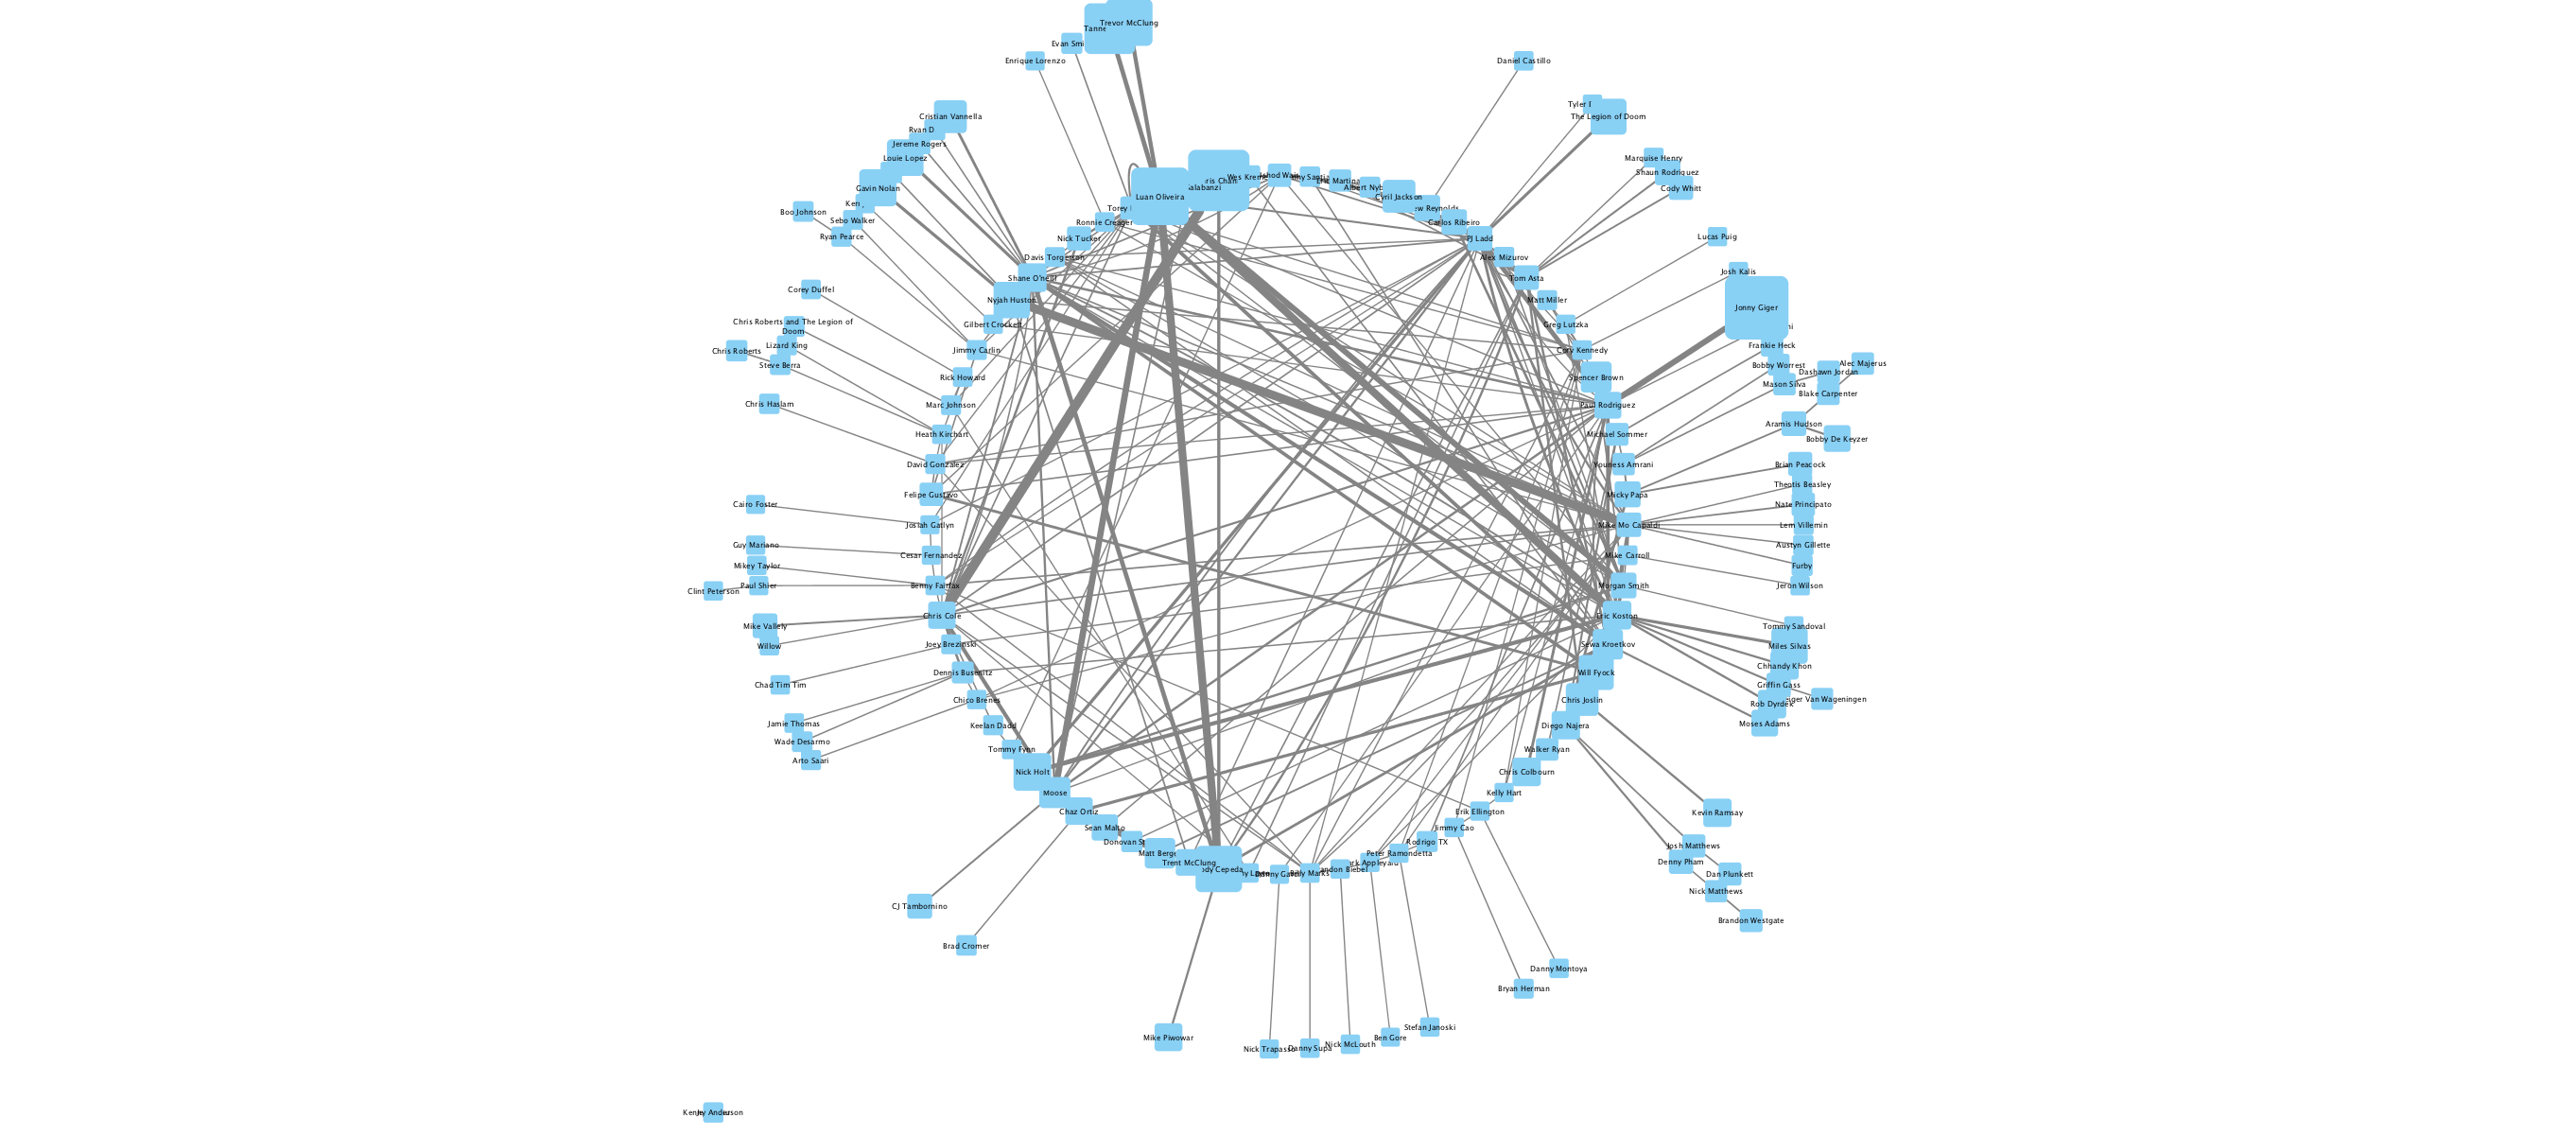

In [17]:
# Let's take a look at the network with nodes and edges
# representing most watched skaters and videos
from IPython.display import Image
Image(cy_net.get_png())

In [18]:
# Getting skateboarders battles
from py2cytoscape.data.util_network import NetworkUtil as util

# Let's see the battles of the skater Eric Koston
skater_name = 'Eric Koston'
name_map = util.name2suid(cy_net)
skater = name_map[skater_name]

# Changing skateboarder color
view.update_node_views(visual_property='NODE_FILL_COLOR', values=set_value([skater], 'red'))

# Getting opponents (neighbour nodes)
opponents = cy_net.get_neighbours(skater)

# Getting battles (adjacent edges)
battles   = cy_net.get_adjacent_edges(skater)

<type 'numpy.int64'>


In [19]:
# Creating a temporary table only with skater battles/opponents
temp_table = all_battles_table[(all_battles_table.source==skater_name) | (all_battles_table.target==skater_name)]

# Sorting table by time of battles (issue and then round)
temp_table_sorted = temp_table.sort_values(['batb_issue', 'round'])

# Creating list to add PNG files
png_files = []

# Going through the table to change the attributes in the network
for t_index in temp_table_sorted.index:
    row = temp_table_sorted.loc[t_index]
    
    # Updating edges properties
    view.update_edge_views(visual_property='EDGE_STROKE_UNSELECTED_PAINT', values=set_value([t_index], 'orange'))
    if skater_name == row['source']:
        opponent = row['target']
    else:
        opponent = row['source']
    
    skater_index = all_skaters_table.index[all_skaters_table.name == opponent][0]
    #print(row['video_title'])
    
    # Updating nodes properties
    view.update_node_views(visual_property='NODE_FILL_COLOR', values=set_value([skater_index], 'orange'))

    # Each time a edge/node changes, we save a new file (to create an animation later)
    png_name = 'battle_network_' + str(t_index) + '.png'
    png_files.append(png_name)
    image_file = open(png_name, 'wb')
    image_file.write(cy_net.get_png())
    image_file.close()
    

<type 'numpy.int64'>
<type 'numpy.int64'>
<type 'numpy.int64'>
<type 'numpy.int64'>
<type 'numpy.int64'>
<type 'numpy.int64'>
<type 'numpy.int64'>
<type 'numpy.int64'>
<type 'numpy.int64'>
<type 'numpy.int64'>
<type 'numpy.int64'>
<type 'numpy.int64'>
<type 'numpy.int64'>
<type 'numpy.int64'>
<type 'numpy.int64'>
<type 'numpy.int64'>
<type 'numpy.int64'>
<type 'numpy.int64'>
<type 'numpy.int64'>
<type 'numpy.int64'>
<type 'numpy.int64'>
<type 'numpy.int64'>
<type 'numpy.int64'>
<type 'numpy.int64'>
<type 'numpy.int64'>
<type 'numpy.int64'>
<type 'numpy.int64'>
<type 'numpy.int64'>
<type 'numpy.int64'>
<type 'numpy.int64'>
<type 'numpy.int64'>
<type 'numpy.int64'>
<type 'numpy.int64'>
<type 'numpy.int64'>


In [20]:
# Creating GIF (animation) with individual PNG files
import imageio
images = [imageio.imread(png_file) for png_file in png_files]
kargs = { 'duration': 1 }
imageio.mimsave('battles_network.gif', images, 'GIF', **kargs)

In [21]:
# Now, open the GIF with the IPython notebook
Image(url='battles_network.gif')

In [22]:
# EXTRA
# Saving network json to load with Cytoscape.js, reload with Cytoscape CyREST
net_json = cy_net.to_json()
net_json_file = open('skaters_network.json', 'w')
net_json_file.write(json.dumps(net_json, indent=4, separators=(',', ': ')))
net_json_file.close()